# Exercise - Knowledge Base Agent - STARTER

In this exercise, you’ll build a Knowledge Base Agent using LangGraph, which can:

Efficiently process long documents using text embedding and chunking.
Retrieve information from a vector database.
Augment user queries with retrieved contextual documents.
Generate accurate responses using an LLM.


**Scenario**

You’re building a support assistant for a company that maintains a large set of internal documentation, such as FAQs, policy guides, and how-to manuals. The assistant should be able to:

Search through the documentation
Retrieve the most relevant sections
Provide helpful answers grounded in the retrieved information
This approach, aka Retrieval-Augmented Generation (RAG) — is a powerful technique for building agents that are accurate, verifiable, and up-to-date.


**Challenge**

Your task is to create a LangGraph Workflow that includes:

- A document loading and vectorization process for a knowledge base.
- An Agent Node capable of:
    - Retrieving relevant knowledge.
    - Augmenting responses with contextual documents.
    - Generating accurate answers.
- Conditional routing to control query resolution.
- Optimization techniques such as text chunking and embedding search.

By the end of this exercise, you’ll have built an AI-powered Knowledge Base Agent that uses a structured process to generate accurate answers.



## 0. Import the necessary libs

In [1]:
import os
from typing import List
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from IPython.display import Image, display

## 1. Instantiate Chat Model with your API Key

To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the `api_key` argument directly.
```python
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)
```

In [2]:
# TODO - Instantiate your chat model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url="https://openai.vocareum.com/v1",
    api_key = os.getenv("VOCAREUM_OPENAI_API_KEY"),
)

In [3]:
# TODO - Instantiate your embeddings model
embeddings_fn = OpenAIEmbeddings(
    model="text-embedding-3-large",
    base_url="https://openai.vocareum.com/v1",
    api_key = os.getenv("VOCAREUM_OPENAI_API_KEY"),
)

## 2. Load and Process Documents

In [4]:
# TODO create your Chroma vector store with a collection name 
# and the embedding function
vector_store =  Chroma(
    collection_name="knowledge-base",
    embedding_function=embeddings_fn,
    persist_directory="chromadb",
)

In [5]:
file_path = "compact-guide-to-large-language-models.pdf"

In [6]:
loader = PyPDFLoader(file_path)

In [7]:
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [8]:
# TODO - Create a text splitter with chunk_size and chunk_overlap 
# values of 1000 and 200, respectively
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

In [9]:
all_splits = text_splitter.split_documents(pages)

In [10]:
_ = vector_store.add_documents(documents=all_splits)

## 3. Define State Schema

We define a State Schema for managing:

- User query
- Retrieved documents
- Generated answer

In [11]:
# TODO - Create your state schema named State inheriting from MessagesState
# with question(str), documents(List) and answer(str) attributes
class State(MessagesState):
    question: str
    documents: List[Document]
    answer: str

## 4. RAG Nodes

The agent should:
- fetch relevant document chunks based on the user query
- combine the retrieved documents and use them as context
- invoke the LLM to generate a response

In [12]:
def retrieve(state: State):
    question = state["question"]

    # TODO - Use the vector store to retrieve similar documents to the question
    # Use the similarity_search() method
    retrieved_docs = vector_store.similarity_search(question, k=3)

    return {"documents": retrieved_docs}

In [13]:
def augment(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)

    # TODO - Create a RAG ChatPromptTemplate with question and context variables
    template = ChatPromptTemplate.from_messages([
        ("system",
        """"
        You are a helpful assistant that can answer questions based on the provided context. If the answer is not found in the context, just say 'I don't know', explicitly mention the source of the answer.
        
        Context: {context}
        """),
        ("user", "{question}")
    ])

    messages = template.invoke(
        {"context": docs_content, "question": question}
    ).to_messages()

    return {"messages": messages}

In [14]:
def generate(state: State):
    # TODO - Invoke the LLM passing the messages from state
    ai_message = llm.invoke(state["messages"])

    return {"answer": ai_message.content, "messages": ai_message}

## 5. Build the LangGraph Workflow

In [15]:
workflow = StateGraph(State)
# TODO - add all the nodes and edges

# adding nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("augment", augment)
workflow.add_node("generate", generate)

# adding edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "augment")
workflow.add_edge("augment", "generate")
workflow.add_edge("generate", END)


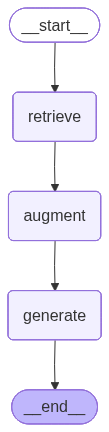

In [16]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

## 6. Invoke the Agent with a Query

Run and Print the retrieved documents to check search accuracy.

In [31]:
output = graph.invoke(
    {"question": "what are all the LLM models mentioned in the documents"}
)

In [32]:
output["answer"]

"I don't know. The provided context does not mention any specific LLM models."

In [33]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================

"
        You are a helpful assistant that can answer questions based on the provided context. If the answer is not found in the context, just say 'I don't know', explicitly mention the source of the answer.

        Context: others can more easily digest the content. LLMs can take large amounts of 
text and boil it down to just the most important bytes.
CONTENT GENERATION  
Start with a detailed prompt and have an LLM develop an outline for you. 
Then continue on with those prompts and LLMs can generate a good first 
draft for you to build off. Use them to brainstorm ideas, and ask the LLM 
questions to help you draw inspiration from. 
Note: Most LLMs are not trained to be fact machines. They know how to use 
language, but they might not know who won the big sporting event last year. 
It’s always important to fact check and understand the responses before 
using them as a reference.

others can more easi

## 7. Experiment

Now that you understood how it works, experiment with new things.

- Change the embedding model
- Change the parameters of RecursiveCharacterTextSplitter(chunk_size and chunk_overlap)
- Use your own document
- Add More File Types